## **1. Import các thư viện cần thiết**

In [1]:
import os   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1

## **2. Trực quan hóa dữ liệu**

In [2]:
dataset_filepath = 'AAPL.csv' # Khai báo đường dẫn đến file .csv của bộ dữ liệu
df = pd.read_csv(dataset_filepath, index_col=0) # Đọc file .csv thành DataFrame
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-22,44.325001,44.445000,44.150002,44.250000,42.077320,108434400
2018-01-23,44.325001,44.860001,44.205002,44.259998,42.086819,130756400
2018-01-24,44.312500,44.325001,43.299999,43.555000,41.416439,204420400
2018-01-25,43.627499,43.737499,42.632500,42.777500,40.677120,166116000
2018-01-26,43.000000,43.000000,42.514999,42.877499,40.772205,156572000
...,...,...,...,...,...,...
2023-01-13,132.029999,134.919998,131.660004,134.759995,134.759995,57758000
2023-01-17,134.830002,137.289993,134.130005,135.940002,135.940002,63646600
2023-01-18,136.820007,138.610001,135.029999,135.210007,135.210007,69672800


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,98.934641,100.140912,97.772438,99.000508,97.745474,1.165779e+08
std,46.090021,46.680638,45.481456,46.100731,46.466743,5.517977e+07
min,35.994999,36.430000,35.500000,35.547501,34.309582,3.519590e+07
25%,51.417500,51.896250,50.942499,51.523750,49.871328,7.950650e+07
50%,96.562500,97.254997,95.257500,96.327499,94.849915,1.017869e+08
75%,142.760002,144.474998,141.004997,142.864998,142.167084,1.369496e+08
max,182.630005,182.940002,179.119995,182.009995,180.959747,4.265100e+08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2018-01-22 to 2023-01-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9+ KB


In [5]:
df.shape

(1259, 6)

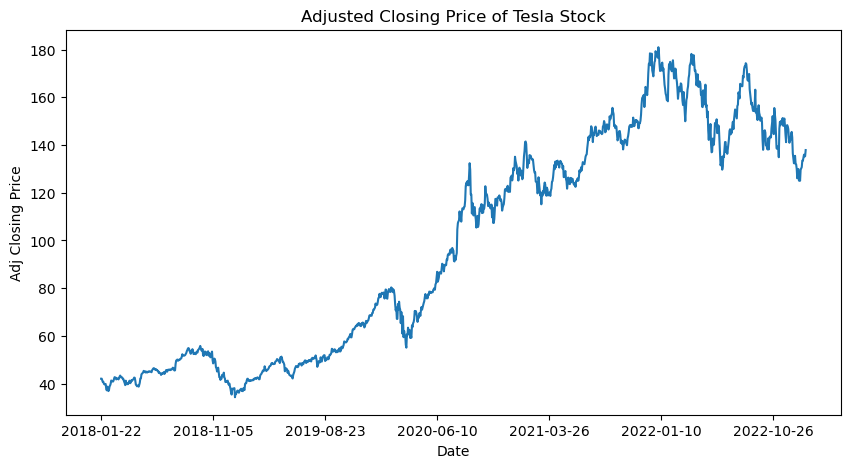

In [6]:
plt.figure(figsize=(10, 5))
df['Adj Close'].plot()
plt.title('Adjusted Closing Price of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Adj Closing Price')
plt.show()

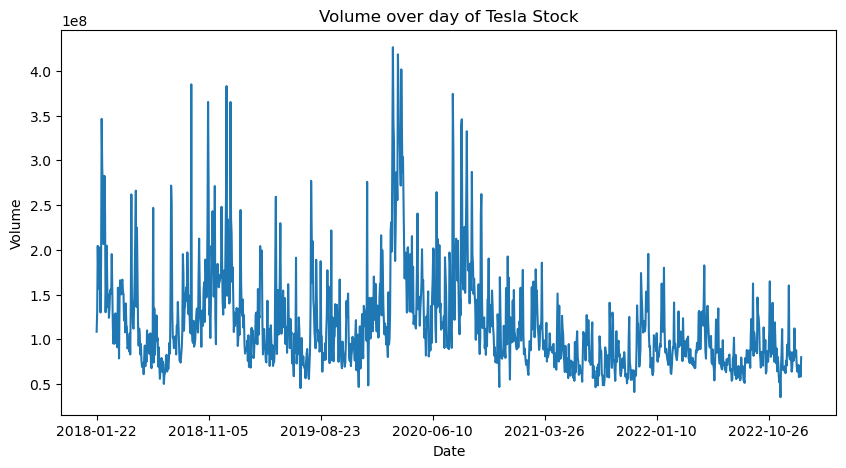

In [7]:
plt.figure(figsize=(10, 5))
df['Volume'].plot()
plt.title('Volume over day of Tesla Stock')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

## **3. Chuẩn bị dữ liệu**

In [8]:
# Khai báo hàm Windowing (dùng để tạo các cặp X, y cho time series data)
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = [] # Khai báo list dùng để lưu trữ các y

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size 
    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[feature_start_idx:feature_end_idx] # Lấy X
        label = df[label_name][label_start_idx:label_end_idx] # Lấy y

        features.append(feature) 
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [9]:
INPUT_SIZE = 30 
LABEL_SIZE = 1 
OFFSET = 1
BATCH_SIZE = 32
TARGET_NAME = 'Adj Close'

In [10]:
dataset_length = len(df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.7 # Tỉ lệ kích thước tập train
VAL_SIZE = 0.2 # Tỉ lệ kích thước tập val
# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length) 
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

# Khởi tạo X, y cho tập train
X_train, y_train = slicing_window(df, 
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập val
X_val, y_val = slicing_window(df, 
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

# Khởi tạo X, y cho tập test
X_test, y_test = slicing_window(df, 
                                  df_start_idx=VAL_END_IDX,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

In [11]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

## **4. Xây dựng mô hình**

In [12]:
model = XGBRegressor()

## **5. Huấn luyện mô hình**

In [13]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## **6. Đánh giá và trực quan hóa**

In [14]:
y_test_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Calculate the evaluation metrics
rmse = ((mean_squared_error(y_test_pred, y_test))**0.5)
mse = mean_squared_error(y_test_pred, y_test)
mae = mean_absolute_error(y_test_pred, y_test)
mape = mean_absolute_percentage_error(y_test_pred, y_test)

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 9.694768419837057
MSE: 93.98853471426993
MAE: 8.000967785317279
MAPE: 0.05827576893276567


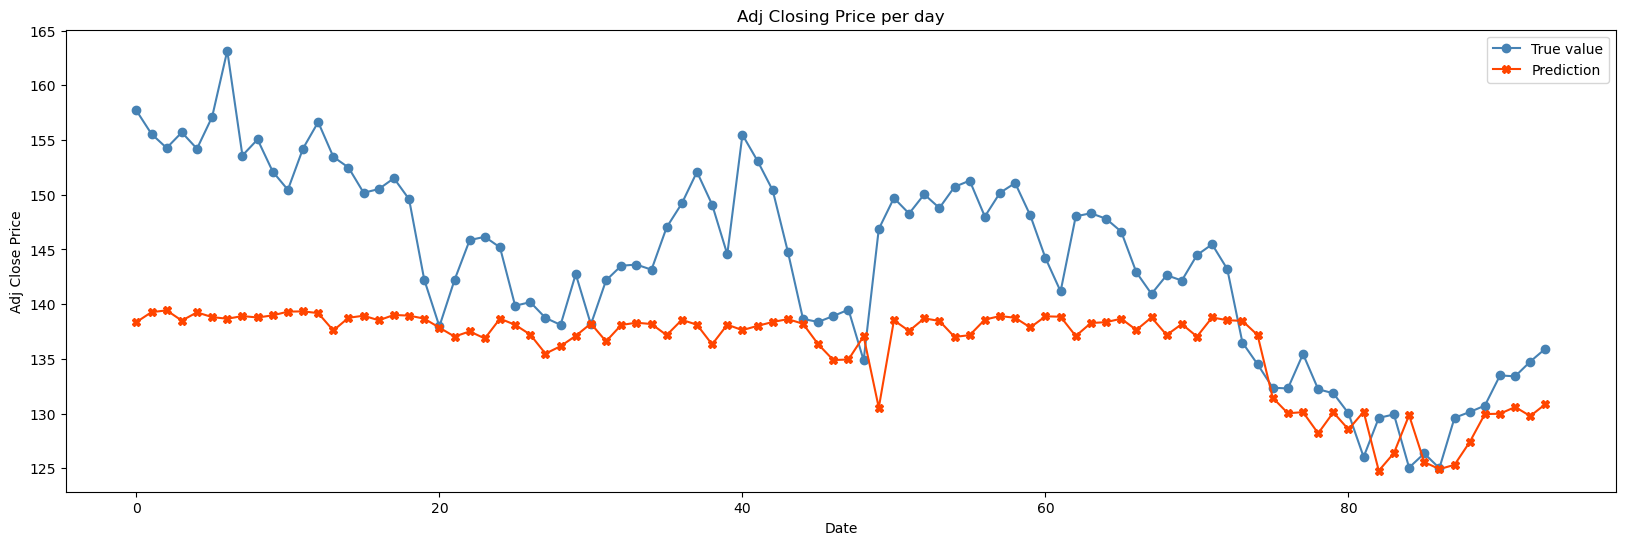

In [15]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Adj Closing Price per day')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test[:300], model.predict(X_test[:300]))